In [2]:
import sys
import sys
sys.path.append('../build/')

from PyGMO import algorithm, island, archipelago
import versor as vsr
%pylab inline
np.set_printoptions(precision=6, suppress=True)

Populating the interactive namespace from numpy and matplotlib


# PK8103 Swarm Intelligence

This notebook implements the swarm intelligence algorithms **Ant Colony Optimization (ACO)**, **Artificial Bee Colony Optimization (ABC)** and **Particle Swarm Optimization (PSO)** for estimation of **rigid body motion motors** from point clouds using **Conformal Geometric Algebra (CGA)**.

## Conformal Geometric Algebra

### Polar Decomposition

$$M = \frac{X}{|X|}\left(1 - \frac{\langle X \widetilde{X} \rangle_4}{2 \langle X \widetilde{X} \rangle} \right),\ X \in \mathbb{M}$$

In [3]:
def polar_decomposition(x):
    xx = x * x.rev()
    sinv = (vsr.Sca(1.0) + (vsr.Drt(- xx[7] / (2 * xx[0]))))
    return x * sinv

### Cost Function

$$ C = \sum_i^n \| \mathcal{K}^{-1}(b_i) - \mathcal{K}^{-1}(M a_i \widetilde{M})    \|^2 $$

In [4]:
def cost_function(m):
    mot = vsr.Mot(*m.ravel())
    mot = polar_decomposition(mot)
    b_ = [point.spin(mot) for point in points_a]
#     b = points_b_noisy
    b = points_b
    return np.sum([np.linalg.norm(pa.to_array()[:3] - 
                                  pb.to_array()[:3]) for pa, pb in zip(b, b_)])

### Dataset generation

In [5]:
n = 10
sigma = 0.01
motor = vsr.Trs.from_vector(vsr.Vec(1,1,1)) * vsr.Rot.from_bivector(vsr.Biv(0,1,0) * np.pi/6.0)
points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() for i in range(n)]
points_b = [point.spin(motor) for point in points_a]
points_b_noisy = [vsr.Vec(*(point.to_array()[:3] + sigma * np.random.randn(3))).null() for point in points_b]

### RMS Distance

In [6]:
def rms_distance(final_motor):
    points_b_estimated = [point.spin(final_motor) for point in points_a]
    rms_distance = np.sum([ np.linalg.norm(a.to_array()[:3] - b.to_array()[:3])
                            for a, b in zip(points_b, points_b_estimated)]) / np.sqrt(n)
    return rms_distance

### PyGMO wrapper

In [7]:
from PyGMO.problem import base
class MotorEstimationProblem(base):
    def __init__(self, dim=8):
        super(MotorEstimationProblem,self).__init__(dim)
        self.set_bounds(-1, 1)
    
    def _objfun_impl(self, x):
        return (cost_function(x), )
    
    def human_readable_extra(self):
        return "\n\t Problem dimension: " + str(self.__dim)

## Artificial Bee Colony Optimization *(ABC)*

In [8]:
# prob = MotorEstimationProblem(dim=8)
# algo = algorithm.bee_colony(gen=1000)
# isl = island(algo, prob, 20)
# isl.evolve(1)
# isl.join()
# print(isl.population.champion.f[0])
# x = isl.population.champion.x
# m_bee = polar_decomposition(vsr.Mot(*x))
# print(m_bee)

In [9]:
class ArtificialBeeColonyAlgorithm(object):
    def __init__(self, 
                 objective_function, 
                 dimension, 
                 upper_bounds,
                 lower_bounds,
                 population_size, 
                 max_trial_limit, 
                 max_num_iterations,
                 debug=False):
        self._objective_function = objective_function
        self._dimension = dimension
        self._lower_bounds = lower_bounds
        self._upper_bounds = upper_bounds
        self._population_size = population_size
        self._food_size = self._population_size / 2
        self._max_trial_limit = max_trial_limit
        self._max_num_iterations = max_num_iterations
        
        self._foods = self._create_food(self._food_size)
        self._objective_values = self._calculate_objective_values(self._foods)
        self._fitness_values = self._calculate_fitness_values(self._objective_values)
        
        self._trials = np.zeros(self._food_size)
        
        self._best_index = np.argmin(self._objective_values)
        self._global_min_objective_value = self._objective_values[self._best_index]
        self._global_min_objective_values = [self._global_min_objective_value]
        self._global_best_food = self._foods[self._best_index,:]
        
        self._debug = debug
    
    def _create_food(self, size):
        food = np.random.random((size, dim)) *\
                np.tile(upper_bounds - lower_bounds, (size,1)) +\
                np.tile(lower_bounds, (size,1))
        return food
    
    def _calculate_objective_values(self, foods):
        return np.array([self._objective_function(solution) for solution in foods])
    
    def _calculate_fitness_values(self, objective_values):
        return np.array([1. / (objective_value + 1.) 
                         if objective_value >= 0. 
                         else 1. + np.abs(objective_value) 
                         for objective_value in objective_values])
    def _evaluate(self, i):
            j = np.random.random_integers(self._dimension) - 1
            k = np.random.random_integers(self._food_size) - 1
            while k == i:
                k = np.random.random_integers(self._food_size) - 1

            v_i = self._foods[i,:].copy()
            x_ij = self._foods[i,j]
            x_kj = self._foods[k,j]
            phi_ij = 2 * (np.random.rand() - 0.5)
            v_i[j] = x_ij + phi_ij * (x_ij - x_kj)

            # Check if parameter is outside bounds. If so set it to the 
            # limit.
            v_i = np.where(v_i < upper_bounds, v_i, upper_bounds).copy()
            v_i = np.where(v_i > lower_bounds, v_i, lower_bounds).copy()

            objective_value = self._calculate_objective_values([v_i])
            fitness_value = self._calculate_fitness_values(objective_value)

            if fitness_value > self._fitness_values[i]:
                self._foods[i,:] = v_i.copy()
                self._fitness_values[i] = fitness_value.copy()
                self._objective_values[i] = objective_value.copy()
                self._trials[i] = 0
            else:
                self._trials[i] = self._trials[i] + 1
        
    def _calculate_probabilities(self, fitness_values):
        '''p_i = fit_i / sum_i^n fit_i'''
        prob = fitness_values / np.sum(fitness_values)
#         prob = (0.9 * fitness_values / max(fitness_values)) + 0.1
        return prob
    
    def solve(self):
        for iteration in range(self._max_num_iterations):
            # Employed bee phase
            for i in range(self._food_size):
                self._evaluate(i)

            # Calculate probabilities. 
            # p_i = fit_i / sum_i^n fit_i
            probabilities = self._calculate_probabilities(self._fitness_values)

            # Onloooker bee phase
            i = 0
            t = 0
            while t < self._food_size:
                do_forage = np.random.rand() < probabilities[i]
                if do_forage:
                    t = t + 1
                    self._evaluate(i)
                i = i + 1
                if i == self._food_size:
                    i = 0

            # Update best solution
            best_index = np.argmin(self._objective_values)
            objective_value = self._objective_values[best_index]
            if objective_value < self._global_min_objective_value:
                self._best_index = best_index
                self._global_min_objective_value = objective_value
                self._global_best_food = self._foods[best_index,:]

            # Scout bee phase
            max_trial_idx = np.argmax(self._trials)
            max_trial = self._trials[max_trial_idx]
            if max_trial > self._max_trial_limit:
                self._trials[max_trial_idx] = 0
                v_i = self._create_food(1)
                objective_value = self._calculate_objective_values([v_i])
                fitness_value = self._calculate_fitness_values(objective_value)
                self._foods[max_trial_idx, :] = v_i.copy()
                self._fitness_values[max_trial_idx] = fitness_value.copy()
                self._objective_values[max_trial_idx] = objective_value

            self._global_min_objective_values.append(self._global_min_objective_value)
            if self._debug:
                if not iteration % 50:
                    print('Iteration: {}, f(x_i)_min: {}, i: {}'.format(iteration, 
                                                                        self._global_min_objective_value, 
                                                                        self._best_index))
        return self._global_best_food
    
    def plot(self):
        plt.plot(self._global_min_objective_values)
        plt.xscale('log')

In [10]:
population_size = 20
max_trial_limit = 80
max_num_iterations = 2000
dim = 8
upper_bounds = np.ones((1,dim)) * 1
lower_bounds = np.ones((1,dim)) * -1
abc = ArtificialBeeColonyAlgorithm(cost_function, dim, 
                                   upper_bounds, lower_bounds, 
                                   population_size, max_trial_limit, 
                                   max_num_iterations, debug=True)

In [11]:
m_bee = abc.solve()

Iteration: 0, f(x_i)_min: 22.4060347951, i: 9
Iteration: 50, f(x_i)_min: 3.68256238517, i: 9
Iteration: 100, f(x_i)_min: 1.16895904149, i: 9
Iteration: 150, f(x_i)_min: 0.728810856463, i: 9
Iteration: 200, f(x_i)_min: 0.235094256397, i: 9
Iteration: 250, f(x_i)_min: 0.163124017769, i: 9
Iteration: 300, f(x_i)_min: 0.163124017769, i: 9
Iteration: 350, f(x_i)_min: 0.163124017769, i: 9
Iteration: 400, f(x_i)_min: 0.163124017769, i: 9
Iteration: 450, f(x_i)_min: 0.105109947851, i: 3
Iteration: 500, f(x_i)_min: 0.0699819886072, i: 3
Iteration: 550, f(x_i)_min: 0.0454650755784, i: 5
Iteration: 600, f(x_i)_min: 0.0399885964231, i: 3
Iteration: 650, f(x_i)_min: 0.0247655972821, i: 3
Iteration: 700, f(x_i)_min: 0.0192974756967, i: 3
Iteration: 750, f(x_i)_min: 0.0163678266621, i: 3
Iteration: 800, f(x_i)_min: 0.0109411223464, i: 9
Iteration: 850, f(x_i)_min: 0.00703499070999, i: 3
Iteration: 900, f(x_i)_min: 0.0053991097854, i: 3
Iteration: 950, f(x_i)_min: 0.00422352366204, i: 9
Iteration: 100

<Container object of 10 artists>

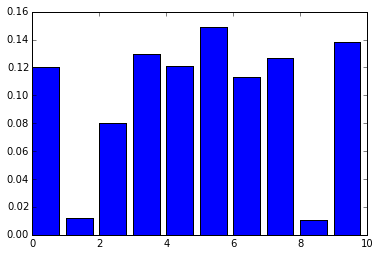

In [13]:
plt.bar(np.arange(10),abc._calculate_probabilities(abc._fitness_values))

In [14]:
m_bee = polar_decomposition(vsr.Mot(*m_bee))
print(m_bee)


0.965743  0.00519804  -0.25598  -0.00106484  -0.607621  -0.486423  -0.354073  -0.130167  


In [15]:
rms_distance(vsr.Mot(*m_bee.to_array()))

0.033358165395865294

## Particle Swarm Optimization *(PSO)*

In [ ]:
prob = MotorEstimationProblem(dim=8)
algo = algorithm.pso(gen=1000)
isl = island(algo, prob, 20)
isl.evolve(1)
isl.join()
print(isl.population.champion.f[0])
x = isl.population.champion.x
m_pso = polar_decomposition(vsr.Mot(*x))
print(m_pso)

In [ ]:
rms_distance(m_pso)

### Genetic Algorithm

In [ ]:
prob = MotorEstimationProblem(dim=8)
algo = algorithm.sga(gen=4000)
isl = island(algo, prob, 10)
isl.evolve(1)
isl.join()
print(isl.population.champion.f[0])
x = isl.population.champion.x
m_sga = polar_decomposition(vsr.Mot(*x))
print(m_sga)

In [ ]:
rms_distance(m_sga)

## Ant Colony Optimization for Continuous Domains *(ACO$_\mathbb{R}$)*

In [ ]:
from fatiando.inversion.solvers import acor
print(motor)
solver = acor(cost_function, [-1,1], 8, nants=2, diverse=0.5, maxit=30000)
iterations = 0
residuals = []
for p in solver:
    iterations = iterations + 1
    residual = cost_function(p)
    residuals.append(residual)
    continue
m_ant = polar_decomposition(vsr.Mot(*p))
print(m_ant)
print(iterations)

In [ ]:
rms_distance(m_ant)

In [ ]:
plt.plot(residuals)
plt.xscale('log')

In [ ]:
from motor_estimation import estimate_motor
summary, m_game = estimate_motor(5,1,10, points_a, points_b)
rms_distance(m_game)